In [ ]:
!pip install git+https://github.com/AlexMa123/phase_reconstruct
!wget "https://onedrive.live.com/download?cid=45D5A10F94E33861&resid=45D5A10F94E33861%21203780&authkey=AMUV4xKs9HGF32A" -O vanderpol_result.npy

In [36]:
import numpy as np
import phase_reconstruct as pr
import matplotlib.pyplot as plt

# Van der pol oscillator
The Van der pol oscillator is described by the equation:
$$\ddot{x}-\mu\left(1-x^{2}\right) \dot{x}+\omega^{2} x=0.05 \xi(t)$$
let $y = \dot{x}$

$$
\begin{eqnarray}
\dot{x} &=& y \\
\dot{y} &=& 0.05 \xi(t) + \mu(1-x^2) y - \omega^2 x
\end{eqnarray}
$$

My simulation is based on the Euler-Maruyama algorithm with time step $dt = 0.01$.

The time range is (0, 10000), and initial condition is [2, 0]

Text(0, 0.5, 'y')

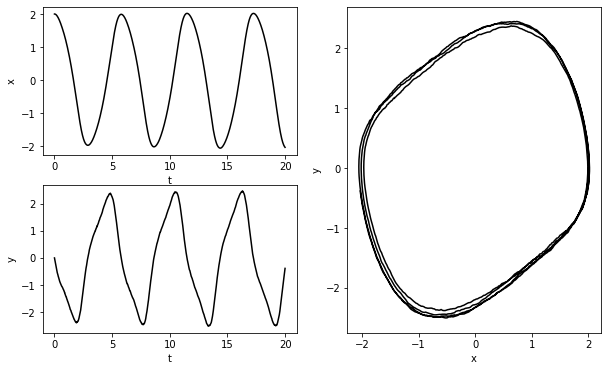

In [113]:
vdp_oscillator = np.load("vanderpol_result.npy")
t = vdp_oscillator[0]
x = vdp_oscillator[1]
y = vdp_oscillator[2]

plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.plot(t[0*100 : 20*100], x[0*100 : 20*100], 'k')
plt.xlabel("t")
plt.ylabel("x")
plt.subplot(223)
plt.plot(t[0*100 : 20*100], y[0*100 : 20*100], 'k')
plt.xlabel("t")
plt.ylabel("y")
plt.subplot(122)
plt.plot(x[0*100 : 20*100], y[0*100 : 20*100], 'k')
plt.xlabel("x")
plt.ylabel("y")

## Signals
Use four signal to get the protophase

$$Y_1 = x, (Y_0 = 0, \hat{Y_0} = 0)$$

$$Y_2 = x, (Y_0 = 0, \hat{Y_0} = 0.8)$$

$$Y_3 = \exp{[x]} - 2.2, (Y_0 = 0, \hat{Y_0} = 0)$$

$$Y_4 = (x^2 - 1.7) x, (Y_0 = 0, \hat{Y_0} = 0)$$

## Get protophase

There are two ways to get protophase

1. using hilbert plane phase

$$ \theta = arctan\left(\frac{S_H - \hat{Y_0}}{S - Y_0} \right)$$

where S is the signal and $S_H$ is the hilbert transform of the signal

The function used to calculate protophase by this method is:
```python
phase_reconstruct.tools.get_protophase_hilbert(signal, y0, y0_hat)
```
The phase is from 0 to 2 $\pi$

and one can use the function
```python
phase_reconstruct.tools.flatten_phase(signal, threshold=5)
```
to make the phase from 0 to $\infty$

2. General events method

$$ \theta = 2\pi \frac{L(t) - L(t_i)}{L(t_{i + 1}) - L(t_i)} + 2\pi i, \text{ where }t_i < t < t_{i + 1}$$

The function is:
```python
phase_reconstruct.tools.get_protophase(signal, events_index)
```
the events_index are integer numbers

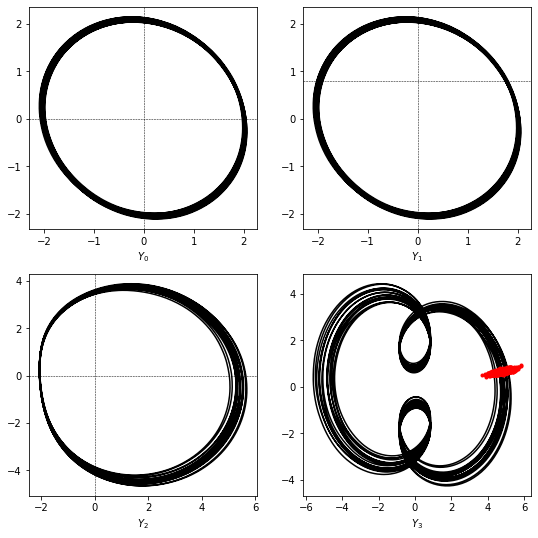

In [114]:
signals = [x, x, np.exp(x) - 2.2, (x**2 - 1.7) * x]
center = [(0, 0), (0, 0.8), (0, 0), (0, 0)]
start = [0, 0.25, 1.5, 2.0]
# calculate protophase
protophase = np.empty(4, dtype=object)
for i in range(3):
    (y0, y0_hat) = center[i]
    signal = signals[i]
    protophase[i] = pr.tools.get_protophase_hilbert(signal, y0, y0_hat)
    if i == 0:
        protophase[i], shift_place = pr.tools.flatten_phase(protophase[i]) # shift place is where the protophase jump from 2pi to 0
    else:
        protophase[i], _ = pr.tools.flatten_phase(protophase[i]) # shift place is where the protophase jump from 2pi to 0

    protophase[i] = protophase[i][shift_place[5] + 10: shift_place[-5]]
    phase_shift = protophase[i][0] - start[i]
    protophase[i] = protophase[i] - phase_shift

t = t[:protophase[0].size]    

protophase[3] = pr.tools.get_protophase(signals[3], shift_place)
protophase[3] = protophase[3][shift_place[5] + 10: shift_place[-5]]
phase_shift = protophase[3][0] - start[3]
protophase[3] = protophase[3] - phase_shift

T0 = (shift_place[-5] - shift_place[5]) * 0.01 / (shift_place.size - 10)
omega0 = 2 * np.pi / T0

plt.figure(figsize = (9, 9))
for i in range(4):
    plt.subplot(221 + i)
    signal = signals[i]
    sa = pr.tools.hilbert(signal)[10 * 100: 110 * 100]
    plt.plot(sa.real, sa.imag, 'k')
    if i < 3:
        plt.axhline(center[i][1], color='k', linestyle='dashed', linewidth=0.5)
        plt.axvline(center[i][0], color='k', linestyle='dashed', linewidth=0.5)
    plt.xlabel("$Y_{}$".format(i))
sa = pr.tools.hilbert(signal)
plt.plot(sa.real[shift_place[5:-5]], sa.imag[shift_place[5:-5]], 'r.', label="poincare section")

## From protophase to phase

using function 
```python
phase_reconstruct.get_phase.proto_to_phase(protophase, Num_of_fourier_terms)
```
which is based on fourier transform

or use the function:
```python
phase_reconstruct.get_phase.proto_to_phase_fast(protophase, nbins)
```
which is based on the CDF of protophase

In [115]:
phase = np.empty(4, dtype=object)
phase_fast = np.empty(4, dtype=object)
for i in range(4):
    phase[i] = pr.get_phase.proto_to_phase(protophase[i], 48).real
    phase[i], _ = pr.tools.flatten_phase(phase[i])
    phase_fast[i] = pr.get_phase.proto_to_phase_fast(protophase[i], 1000)
    phase_fast[i], _ = pr.tools.flatten_phase(phase_fast[i])

(-0.5, 3.0)

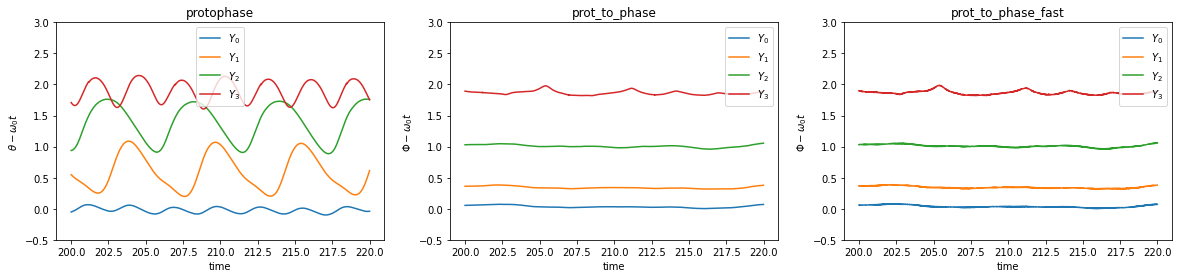

In [116]:
plt.figure(figsize=(20, 4))
ax = plt.subplot(131)
for i in range(4):
    line = protophase[i] - omega0 * t
    plt.plot(t[200*100: 220*100], line[200*100: 220*100], label=f"$Y_{i}$")
    plt.xlabel("time")
    plt.ylabel(r"$\theta - \omega_0 t$")
ax.set_title("protophase")
plt.legend()
plt.ylim([-0.5, 3])

ax = plt.subplot(132)
for i in range(4):
    line = phase[i] - omega0 * t
    plt.plot(t[200*100: 220*100], line[200*100: 220*100], label=f"$Y_{i}$")
    plt.xlabel("time")
    plt.ylabel(r"$\Phi - \omega_0 t$")
ax.set_title("prot_to_phase")
plt.legend()
plt.ylim([-0.5, 3])

ax = plt.subplot(133)
for i in range(4):
    line = phase_fast[i] - omega0 * t
    plt.plot(t[200*100: 220*100], line[200*100 : 220*100], label=f"$Y_{i}$")
    plt.xlabel("time")
    plt.ylabel(r"$\Phi - \omega_0 t$")

ax.set_title("prot_to_phase_fast")
plt.legend()
plt.ylim([-0.5, 3])

In [86]:
%timeit pr.get_phase.proto_to_phase_fast(protophase[i], 1000)

10 loops, best of 3: 53.9 ms per loop


In [87]:
%timeit pr.get_phase.proto_to_phase(protophase[i], 48).real

1 loop, best of 3: 6.43 s per loop


## Long time behavior
(manually add a phase shift to the phase and phase_fast, for splitting these 3 lines)

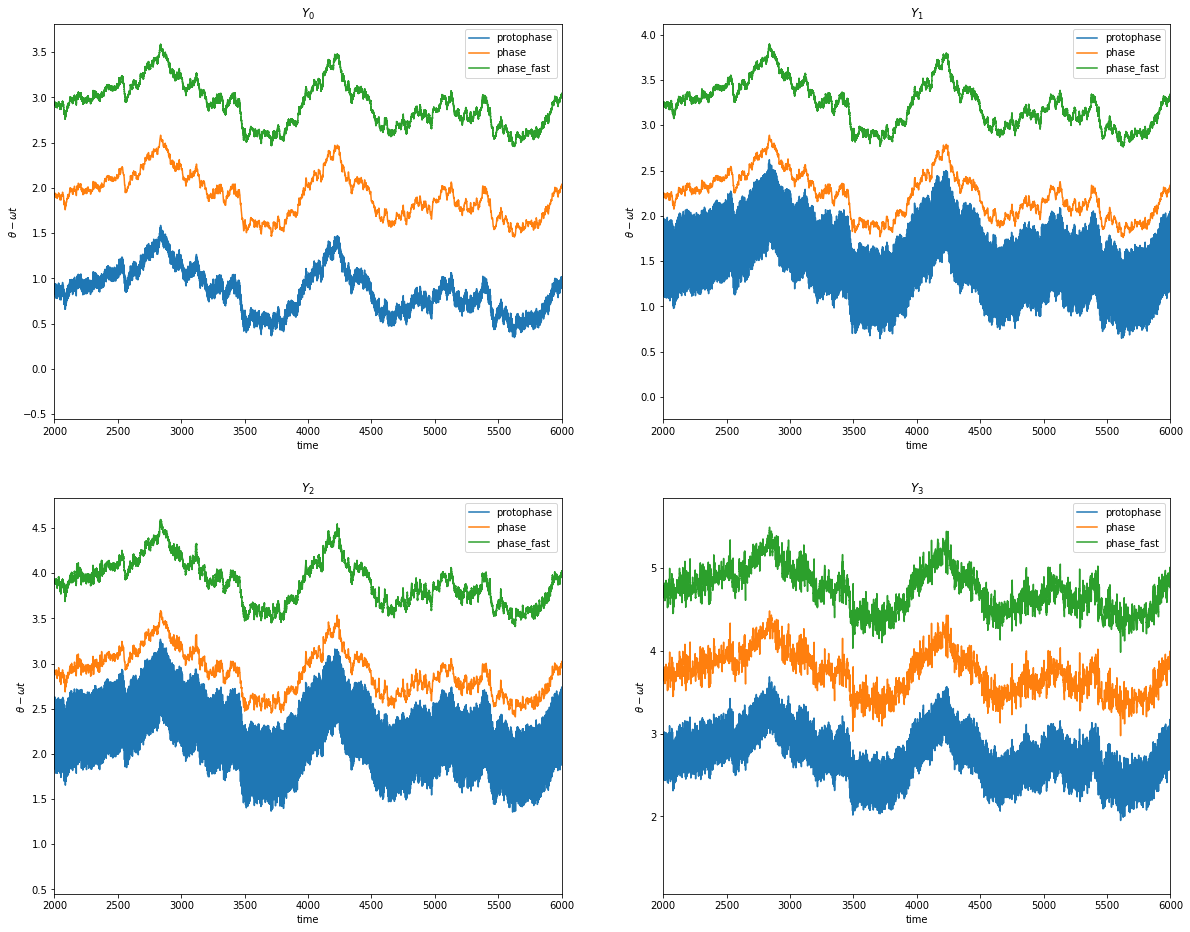

In [132]:
plt.figure(figsize=(20, 16))
for i in range(4):
    ax = plt.subplot(221 + i)
    plt.plot(t, protophase[i] - omega0 * t, label="protophase")
    plt.plot(t, phase[i] - omega0 * t + 1, label="phase")
    plt.plot(t, phase_fast[i] - omega0 * t + 2, label="phase_fast")
    ax.set_title(f"$Y_{i}$")
    plt.xlim([2000, 6000])
    plt.xlabel("time")
    plt.ylabel(r"$\theta - \omega t$")
    plt.legend()

## Phase distribution

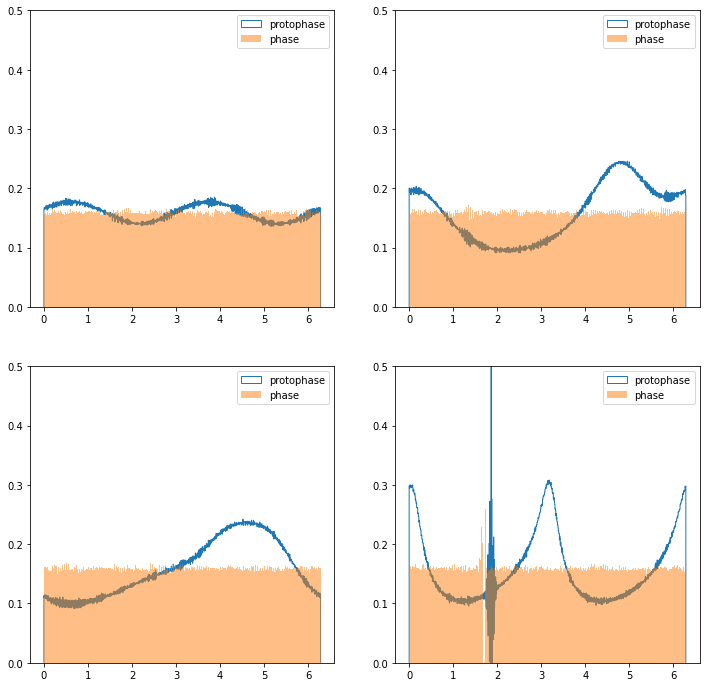

In [141]:
plt.figure(figsize=(12, 12))
for i in range(4):
    ax = plt.subplot(221 + i)
    plt.hist(protophase[i] % (2 * np.pi), bins=1000, density=True, histtype="step", label="protophase")
    plt.hist(phase[i] % (2 * np.pi), bins=1000, density=True, alpha=0.5, label="phase")
    plt.ylim([0, 0.5])
    plt.legend()
plt.show()